<a href="https://colab.research.google.com/github/Yewon-dev/boostcamp-AI-Tech/blob/master/TIL/%5BBasic%5DCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution
- Continuous convolution
- Discrete convolution
- 2D image convolution

## Stack of Convolution
<img src="https://media.vlpt.us/images/naem1023/post/46095895-ee37-4209-b73e-22e11585427a/image.png" width=400> 


# Convolution Neural Networks
- Convolution and pooling layer : feature extraction
- Fully connected layer: decision making
- layer의 parameter, 전체의 parameter 숫자를 확인해야 한다.

## Stride
- filter 이동하는 간격

## Padding
- feature map의 크기가 줄어드는 것을 방지하기 위해 가장자리에 특정 값을 채워 넣는다.


## 1$×$1 Convolution
>Why? 

- **Dimension reduction**
- 깊이가 깊어지는 동안 parameters의 수를 줄이기 위해
- e.g., bottleneck architecture

-----
# Implementation of CNN
출처 : https://github.com/sjchoi86/upstage-basic-deeplearning/blob/main/notebook/cnn.ipynb

### Import Libraries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.10.0+cu111].
device:[cuda:0].


### Download Dataset

In [3]:
from torchvision import datasets,transforms
mnist_train = datasets.MNIST(root='./data/',train=True,transform=transforms.ToTensor(),download=True)
mnist_test = datasets.MNIST(root='./data/',train=False,transform=transforms.ToTensor(),download=True)
print ("mnist_train:\n",mnist_train,"\n")
print ("mnist_test:\n",mnist_test,"\n")
print ("Done.")

mnist_train:
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor() 

mnist_test:
 Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor() 

Done.


### Data Iterator

In [4]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
print ("Done.")

Done.


### Define Model

In [8]:
class ConvolutionalNeuralNetworkClass(nn.Module):
    """
        Convolutional Neural Network (CNN) Class
    """
    def __init__(self,name='cnn',xdim=[1,28,28],
                 ksize=3,cdims=[32,64],hdims=[1024,128],ydim=10,
                 USE_BATCHNORM=False):
        super(ConvolutionalNeuralNetworkClass,self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.cdims = cdims
        self.hdims = hdims
        self.ydim = ydim
        self.USE_BATCHNORM = USE_BATCHNORM

        # Convolutional layers...(1)
        self.layers = []
        prev_cdim = self.xdim[0]
        for cdim in self.cdims: # for each hidden layer
            self.layers.append(
                nn.Conv2d(in_channels = prev_cdim,
                          out_channels = cdim,
                          kernel_size = self.ksize,
                          stride = (1,1),
                          padding = self.ksize//2)) # convolution 
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) # batch-norm
            self.layers.append(nn.ReLU(True))  # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling 
            self.layers.append(nn.Dropout2d(p=0.5))  # dropout
            prev_cdim = cdim

        # Dense layers
        ## convolution layer을 한줄로 펴기
        self.layers.append(nn.Flatten())
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        for hdim in self.hdims:
            self.layers.append(nn.Linear(prev_hdim,hdim,bias=True))
            self.layers.append(nn.ReLU(True))  # activation
            prev_hdim = hdim
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim,self.ydim,bias=True))

        # Concatenate all layers 
        ## 실제로 네트워크가 만들어지는 과정
        self.net = nn.Sequential()
        for l_idx,layer in enumerate(self.layers):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.net.add_module(layer_name,layer) ## add_module 장점 : 이름을 정할 수 있음
        self.init_param() # initialize parameters
        
    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            
    def forward(self,x):
        return self.net(x)

C = ConvolutionalNeuralNetworkClass(
    name='cnn',xdim=[1,28,28],ksize=3,cdims=[32,64],
    hdims=[32],ydim=10).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(),lr=1e-3)
print ("Done.")

Done.


### Check Parameters


In [9]:
np.set_printoptions(precision=3)
n_param = 0
for p_idx,(param_name,param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array 
        n_param += len(param_numpy.reshape(-1))
        print ("[%d] name:[%s] shape:[%s]."%(p_idx,param_name,param_numpy.shape))
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[ 1.156  0.855 -0.136 -0.348  0.255]
[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[2] name:[net.conv2d_04.weight] shape:[(64, 32, 3, 3)].
    val:[ 0.077  0.058  0.095 -0.048 -0.001]
[3] name:[net.conv2d_04.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]
[4] name:[net.linear_09.weight] shape:[(32, 3136)].
    val:[-0.045  0.036 -0.026  0.007 -0.018]
[5] name:[net.linear_09.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]
[6] name:[net.linear_11.weight] shape:[(10, 32)].
    val:[ 0.246  0.358 -0.133  0.113  0.307]
[7] name:[net.linear_11.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]
Total number of parameters:[119,530].


### Simple Forward Path of the CNN Model

In [10]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
x_numpy = np.random.rand(2,1,28,28) ## random choice
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array
print ("x_torch:\n",x_torch)
print ("y_torch:\n",y_torch)
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy)
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy)

x_torch:
 tensor([[[[0.741, 0.117, 0.039,  ..., 0.192, 0.883, 0.414],
          [0.222, 0.576, 0.529,  ..., 0.458, 0.421, 0.104],
          [0.079, 0.586, 0.948,  ..., 0.146, 0.064, 0.548],
          ...,
          [0.676, 0.474, 0.787,  ..., 0.844, 0.663, 0.936],
          [0.147, 0.436, 0.681,  ..., 0.608, 0.749, 0.032],
          [0.938, 0.045, 0.246,  ..., 0.490, 0.983, 0.248]]],


        [[[0.820, 0.050, 0.126,  ..., 0.657, 0.514, 0.618],
          [0.898, 0.474, 0.452,  ..., 0.832, 0.166, 0.472],
          [0.836, 0.568, 0.428,  ..., 0.196, 0.476, 0.730],
          ...,
          [0.268, 0.114, 0.101,  ..., 0.615, 0.118, 0.016],
          [0.529, 0.135, 0.874,  ..., 0.365, 0.512, 0.412],
          [0.155, 0.985, 0.654,  ..., 0.864, 0.347, 0.819]]]], device='cuda:0')
y_torch:
 tensor([[ 4.498, -1.444, -3.774, -0.333,  0.798, -0.380,  3.357,  3.057, -0.524,
         -3.304],
        [ 3.810, -1.184, -4.467, -0.311, -0.847, -0.415,  2.445,  1.120,  1.924,
         -2.522]], device=

### Evaluation Function

In [11]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct = 0,0
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1,1,28,28).to(device))
            _,y_pred = torch.max(model_pred.data,1)
            n_correct += (y_pred==y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode 
    return val_accr
print ("Done")

Done


### Initial Evaluation

In [12]:
C.init_param() # initialize parameters
train_accr = func_eval(C,train_iter,device)
test_accr = func_eval(C,test_iter,device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.084] test_accr:[0.086].


### Train

In [13]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode ## train mode로 바꿔주는 것이 매우매우 중요
EPOCHS,print_every = 10,1
for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        y_pred = C.forward(batch_in.view(-1,1,28,28).to(device))
        loss_out = loss(y_pred,batch_out.to(device))
        # Update
        optm.zero_grad()         # reset gradient 
        loss_out.backward()      # backpropagate
        optm.step()              # optimizer update
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        train_accr = func_eval(C,train_iter,device)
        test_accr = func_eval(C,test_iter,device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print("Done")

Start training.
epoch:[0] loss:[0.738] train_accr:[0.949] test_accr:[0.950].
epoch:[1] loss:[0.199] train_accr:[0.971] test_accr:[0.971].
epoch:[2] loss:[0.138] train_accr:[0.978] test_accr:[0.978].
epoch:[3] loss:[0.113] train_accr:[0.981] test_accr:[0.982].
epoch:[4] loss:[0.097] train_accr:[0.984] test_accr:[0.983].
epoch:[5] loss:[0.087] train_accr:[0.985] test_accr:[0.983].
epoch:[6] loss:[0.079] train_accr:[0.988] test_accr:[0.985].
epoch:[7] loss:[0.073] train_accr:[0.989] test_accr:[0.987].
epoch:[8] loss:[0.066] train_accr:[0.989] test_accr:[0.987].
epoch:[9] loss:[0.065] train_accr:[0.990] test_accr:[0.987].
Done


### Test

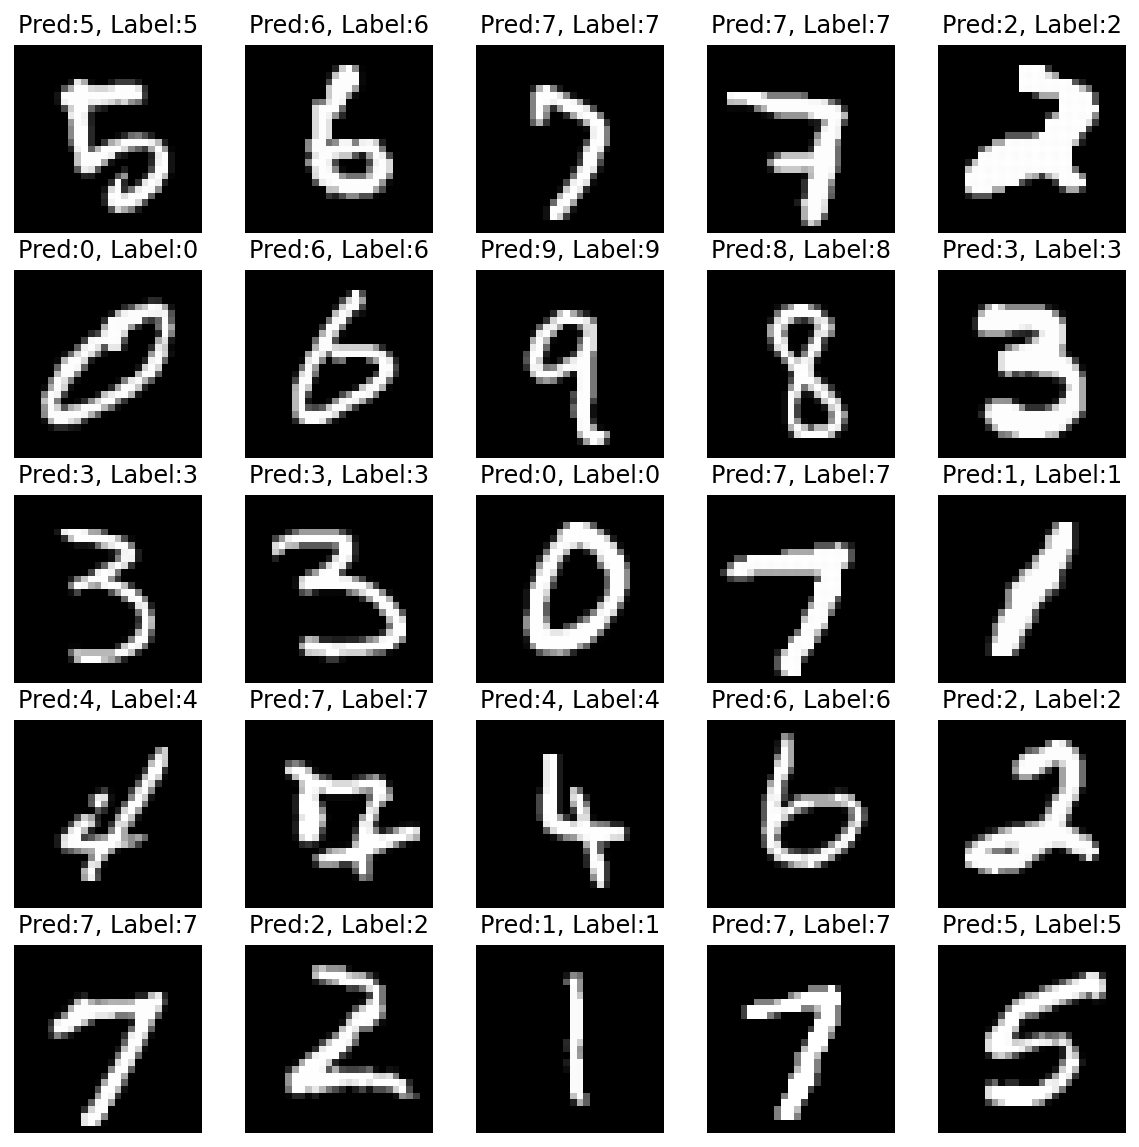

Done


In [14]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets),n_sample,replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]
with torch.no_grad():
    C.eval() # to evaluation mode 
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)
plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5, 5, idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print("Done")